Using this file to check credit metrics that correlate most with XBB - doing this with time series from beginning of ETF life till now

In [1]:
!pip install matplotlib
!pip install numpy 
!pip install pmdarima
!pip install xgboost

In [2]:
# Basic setup 
# libraries 

# SPDR Portfolio Short Term Corp Bond etf (xbb)
#  an index that offers exposure to investment-grade corporate bonds with a remaining maturity ranging from one to three years. 
# The index includes U.S.-dollar denominated, fixed-rate debt.

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas_datareader as web
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Define data sources and time range
start = '2009-01-01'
end = '2024-01-01'

# Checking correlation with XBB 
# Yield, Fed Fund Rates, Interest Rates, Volatility, Inflation, spread 

# Fetching yield data (10-year Treasury yield)
yield_10yr = web.DataReader('GS10', 'fred', start, end)

# Fetching fed fund rates data (Effective Federal Funds Rate)
Fed_rates = web.DataReader('EFFR', 'fred', start, end)

# Fetching Interest Rates iShares Floating Rate Bond ETF
Flot = 'FLOT'
Interest_rates = yf.download(Flot, start=start, end=end)

# Fetching Volatility - using stock index option pricing logic (could maybe try Move)
Vol = web.DataReader('VIXCLS', 'fred', start, end)

# Fetching Inflation - TIP ETF tends to perform well during periods of rising inflation
Tip = 'TIP'
Inflation = yf.download(Tip, start=start, end=end)

# Fetching Spread - ICE BofA US Corporate Index Option-Adjusted Spread
Spread = web.DataReader('BAMLC0A0CM', 'fred', start, end)

# Fetching XBB ETF closing prices
bond = 'XBB'
bond_df = yf.download(bond, start=start, end=end)

# Print the head of each dataset - view full output in OUTPUT1.txt
print("Yield 10 Year:")
print(yield_10yr.head())

print("\nFederal Reserve Rates (EFFR):")
print(Fed_rates.head())

print("\nInterest Rates (iShares Floating Rate Bond ETF):")
print(Interest_rates.head())

print("\nVolatility (VIX CLS):")
print(Vol.head())

print("\nInflation (TIP ETF):")
print(Inflation.head())

print("\nSpread (ICE BofA US Corporate Index Option-Adjusted Spread):")
print(Spread.head())

print("\nBond ETF (XBB):")
print(bond_df.head())


# Combine datasets into a single DataFrame
# data_df = pd.concat([bond_df['Close'], yield_10yr, Fed_rates, Interest_rates, Vol, Inflation, Spread], axis=1)
# data_df.columns = ['Close', 'Yield_10yr', 'EFFR', 'Interest_rates', 'Vol', 'Inflation', 'Spread' ]
# data_df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Yield 10 Year:
            GS10
DATE            
2009-01-01  2.52
2009-02-01  2.87
2009-03-01  2.82
2009-04-01  2.93
2009-05-01  3.29

Federal Reserve Rates (EFFR):
            EFFR
DATE            
2009-01-01   NaN
2009-01-02  0.08
2009-01-05  0.11
2009-01-06  0.09
2009-01-07  0.11

Interest Rates (iShares Floating Rate Bond ETF):
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2011-06-17  50.070000  50.070000  50.070000  50.070000  39.120995     700
2011-06-20  50.669998  50.669998  50.060001  50.060001  39.113152    5900
2011-06-21  50.090000  50.090000  50.090000  50.090000  39.136612    2100
2011-06-22  50.099998  50.099998  50.090000  50.090000  39.136612   13700
2011-06-23  50.099998  50.099998  50.090000  50.099998  39.144447   11100

Volatility (VIX CLS):
            VIXCLS
DATE              
2009-01-01     NaN
2009-01-02   39.19
2009-01-05   39.08
2009-01-06   38.56
2009-01-07 

In [4]:
xbb_yield = pd.concat([bond_df['Close'], yield_10yr], axis=1)
xbb_yield.columns = ['XBB', 'Yield_10yr']
xbb_yield.dropna(inplace=True)

xbb_fedRates = pd.concat([bond_df['Close'],Fed_rates['EFFR']], axis=1)
xbb_fedRates.columns = ['XBB', 'FedRates']
xbb_fedRates.dropna(inplace=True)

xbb_Interest = pd.concat([bond_df['Close'],Interest_rates['Close']], axis=1)
xbb_Interest.columns = ['XBB', 'InterestRates']
xbb_Interest.dropna(inplace=True)

xbb_vol = pd.concat([bond_df['Close'],Vol['VIXCLS']], axis=1)
xbb_vol.columns = ['XBB', 'VIX']
xbb_vol.dropna(inplace=True)

xbb_tips = pd.concat([bond_df['Close'],Inflation['Close']], axis=1)
xbb_tips.columns = ['XBB', 'Inflation(tips)']
xbb_tips.dropna(inplace=True)

xbb_spread = pd.concat([bond_df['Close'],Spread['BAMLC0A0CM']], axis=1)
xbb_spread.columns = ['XBB', 'Spread']
xbb_spread.dropna(inplace=True)

print(xbb_spread)
print(xbb_fedRates)
print(xbb_Interest)
print(xbb_tips)
print(xbb_yield)
print(xbb_vol)
# OUTPUT2.txt


                  XBB  Spread
2022-05-26  41.590000    1.44
2022-05-27  41.654999    1.41
2022-05-31  41.564999    1.40
2022-06-01  41.470001    1.37
2022-06-02  41.439999    1.38
...               ...     ...
2023-12-22  40.240002    1.07
2023-12-26  40.347000    1.06
2023-12-27  40.514999    1.05
2023-12-28  40.200001    1.04
2023-12-29  40.056000    1.04

[401 rows x 2 columns]
                  XBB  FedRates
2022-05-26  41.590000      0.83
2022-05-27  41.654999      0.83
2022-05-31  41.564999      0.83
2022-06-01  41.470001      0.83
2022-06-02  41.439999      0.83
...               ...       ...
2023-12-22  40.240002      5.33
2023-12-26  40.347000      5.33
2023-12-27  40.514999      5.33
2023-12-28  40.200001      5.33
2023-12-29  40.056000      5.33

[398 rows x 2 columns]
                  XBB  InterestRates
Date                                
2022-05-26  41.590000      50.400002
2022-05-27  41.654999      50.369999
2022-05-31  41.564999      50.369999
2022-06-01  41.470001  

In [5]:
# Now, calculating the rolling beta for each indicator with respect to XBB

window = 60  # 60-day rolling window - around 3 months

# Function to calculate rolling beta
def rolling_beta(xbb, indicator, window):
    rolling_cov = xbb.rolling(window).cov(indicator)
    rolling_var = indicator.rolling(window).var()
    return rolling_cov / rolling_var

# Calculate rolling betas for each indicator
xbb_yield['Beta'] = rolling_beta(xbb_yield['XBB'], xbb_yield['Yield_10yr'], window)  

xbb_fedRates['Beta'] = rolling_beta(xbb_fedRates['XBB'], xbb_fedRates['FedRates'], window) 

xbb_Interest['Beta'] = rolling_beta(xbb_Interest['XBB'], xbb_Interest['InterestRates'], window) 

xbb_vol['Beta'] = rolling_beta(xbb_vol['XBB'], xbb_vol['VIX'], window) 

xbb_tips['Beta'] = rolling_beta(xbb_tips['XBB'], xbb_tips['Inflation(tips)'], window) 

xbb_spread['Beta'] = rolling_beta(xbb_spread['XBB'], xbb_spread['Spread'], window) 


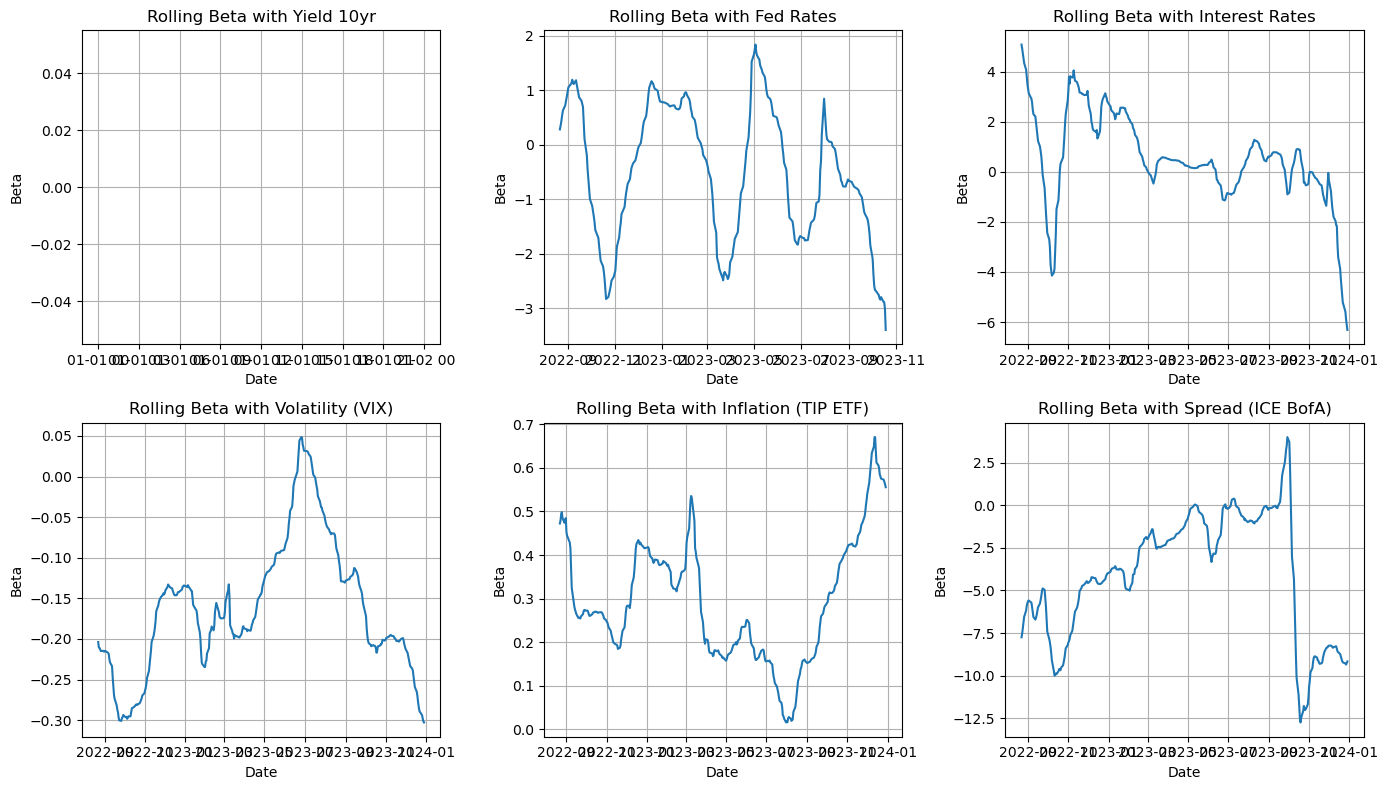

In [6]:

# Plot each rolling beta in separate graphs
plt.figure(figsize=(14, 8))

# Plotting for Beta with Yield 10yr
plt.subplot(2, 3, 1)
plt.plot(xbb_yield['Beta'])
plt.title('Rolling Beta with Yield 10yr')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)

# Plotting for Beta with Fed Rates
plt.subplot(2, 3, 2)
plt.plot(xbb_fedRates['Beta'])
plt.title('Rolling Beta with Fed Rates')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)

# Plotting for Beta with Interest Rates
plt.subplot(2, 3, 3)
plt.plot(xbb_Interest['Beta'])
plt.title('Rolling Beta with Interest Rates')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)

# Plotting for Beta with Volatility (VIX)
plt.subplot(2, 3, 4)
plt.plot(xbb_vol['Beta'])
plt.title('Rolling Beta with Volatility (VIX)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)

# Plotting for Beta with Inflation (TIP ETF)
plt.subplot(2, 3, 5)
plt.plot(xbb_tips['Beta'])
plt.title('Rolling Beta with Inflation (TIP ETF)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)

# Plotting for Beta with Spread (ICE BofA)
plt.subplot(2, 3, 6)
plt.plot(xbb_spread['Beta'])
plt.title('Rolling Beta with Spread (ICE BofA)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



In [8]:
# most similar - least change in beta - is VIX and TIPs ETF --> most constant trends 
# running three models on XBB

data_df = pd.concat([bond_df['Close'], Vol, Inflation['Close']], axis=1)
data_df.columns = ['Close', 'Vol', 'Inflation(Tips)'] 

data_df.dropna(inplace=True)

# Split data into training and testing sets (80% train, 20% test)
train, test = train_test_split(data_df, test_size=0.2, shuffle=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=31.407, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.314, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30.305, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30.303, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.746, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28.758, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.189 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  320
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -12.373
Date:                Fri, 29 Nov 2024   AIC                             26.746
Time:                        00:01:08   BIC                             30.511
Sample:                             0   HQIC                            28.249
                      

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


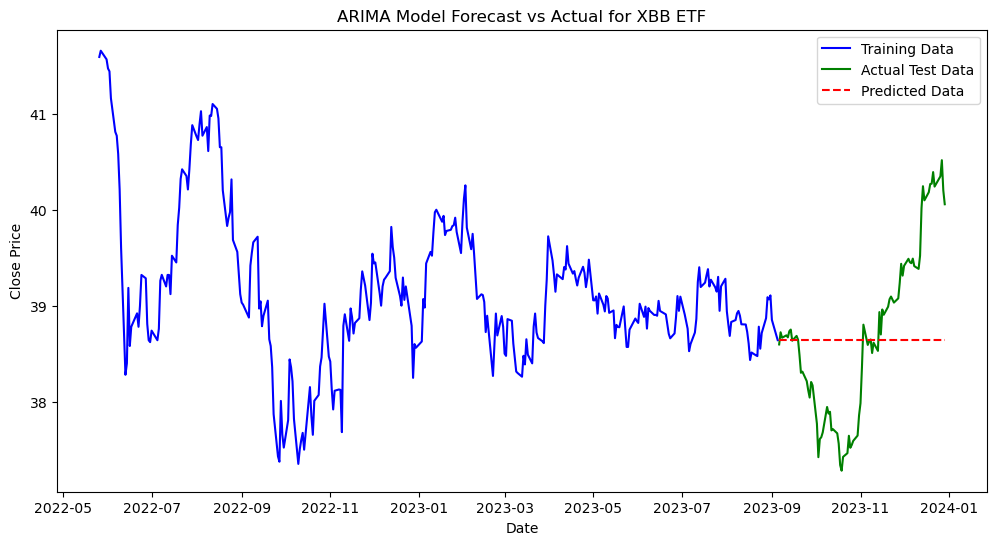

In [9]:
# ARIMA 
model_auto = auto_arima(
    train['Close'],
    exogenous=train[['Vol', 'Inflation(Tips)']],
    seasonal=False,
    stepwise=True,
    trace=True
)
print(model_auto.summary())

# Forecast using the ARIMA model
predictions = model_auto.predict(n_periods=len(test), exogenous=test[['Vol', 'Inflation(Tips)']])

# Evaluate model performance - lower error is better 
mse = mean_squared_error(test['Close'], predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train['Close'], label='Training Data', color='blue', linestyle='-')

# Plot actual test data
plt.plot(test.index, test['Close'], label='Actual Test Data', color='green', linestyle='-')

# Plot predicted test data
plt.plot(test.index, predictions, label='Predicted Data', color='red', linestyle='--')

# Add titles and labels
plt.title("ARIMA Model Forecast vs Actual for XBB ETF")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


Linear Regression Mean Squared Error: 0.2244938369021235


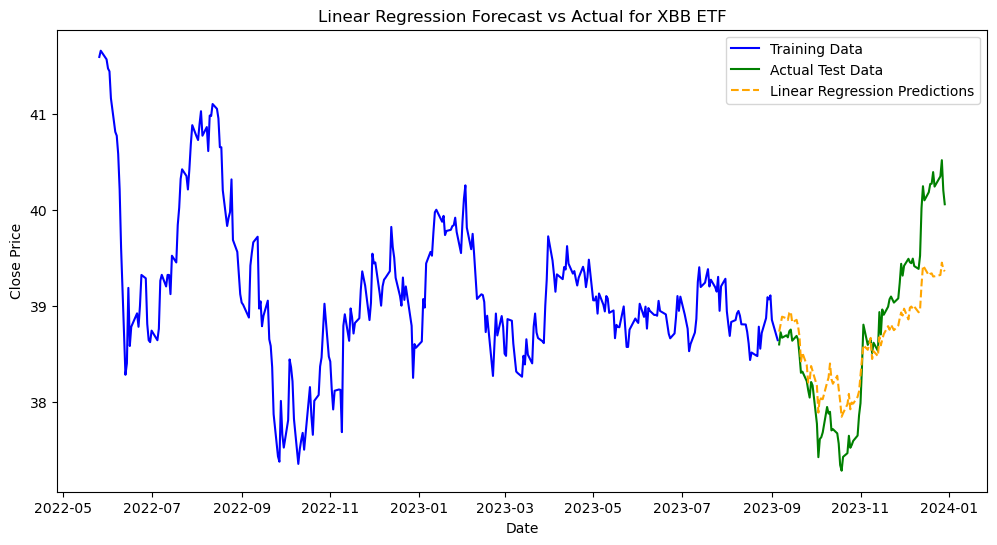

In [10]:
# Linear regression  
# Train the Linear Regression model (using two factors - finding beta) 
lr_model = LinearRegression()
lr_model.fit(train[['Vol', 'Inflation(Tips)']], train['Close'])

# Make predictions for the test set
test['LR_Predictions'] = lr_model.predict(test[['Vol', 'Inflation(Tips)']])

# Calculate performance metrics for Linear Regression - lower number better 
lr_mse = mean_squared_error(test['Close'], test['LR_Predictions'])
print(f"Linear Regression Mean Squared Error: {lr_mse}")

# Plotting 
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train['Close'], label='Training Data', color='blue', linestyle='-')

# Plot actual test data (real results)
plt.plot(test.index, test['Close'], label='Actual Test Data', color='green', linestyle='-')

# Plot Linear Regression predictions
plt.plot(test.index, test['LR_Predictions'], label='Linear Regression Predictions', color='orange', linestyle='--')

plt.title("Linear Regression Forecast vs Actual for XBB ETF")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

XGBoost Mean Squared Error: 0.5837458285117194


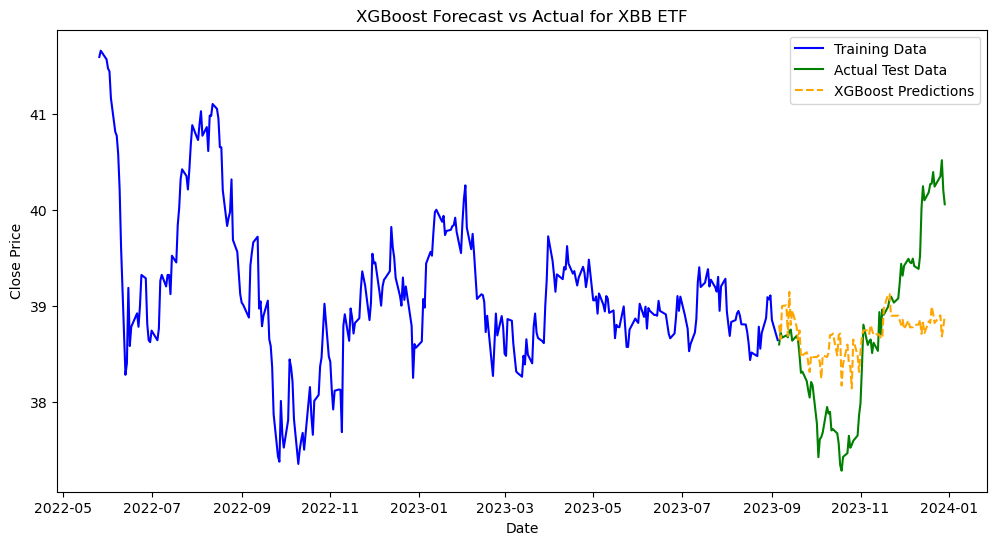

In [11]:

# # XGBOOST
# Prepare the training and test datasets
X_train = train[['Vol', 'Inflation(Tips)']]
y_train = train['Close']
X_test = test[['Vol', 'Inflation(Tips)']]
y_test = test['Close']

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
xgb_model.fit(X_train, y_train)

# Make predictions for the test set
test['XGB_Predictions'] = xgb_model.predict(X_test)

# Calculate performance metrics for XGBoost - lower number better 
xgb_mse = mean_squared_error(y_test, test['XGB_Predictions'])
print(f"XGBoost Mean Squared Error: {xgb_mse}")

# Plotting 
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train['Close'], label='Training Data', color='blue', linestyle='-')

# Plot actual test data (real results)
plt.plot(test.index, test['Close'], label='Actual Test Data', color='green', linestyle='-')

# Plot XGBoost predictions
plt.plot(test.index, test['XGB_Predictions'], label='XGBoost Predictions', color='orange', linestyle='--')

plt.title("XGBoost Forecast vs Actual for XBB ETF")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()